# Udacity Sparkify - Data Warehouse on AWS

In [1]:
import boto3
import json
import configparser
import pandas as pd
from pathlib import Path

In [2]:
from create_resources import main as create_resources
from create_tables import main as create_tables
from etl import main as run_etl
from delete_resources import main as delete_resources

Load configuration parameters

In [4]:
config = configparser.ConfigParser()
config.read_file(open('dwh.cfg'))

AWS_ACCESS_KEY          = config.get('AWS','AWS_ACCESS_KEY')
AWS_SECRET_ACCESS_KEY   = config.get('AWS','AWS_SECRET_ACCESS_KEY')

DWH_REGION              = config.get("CLUSTER","DWH_REGION")
DWH_CLUSTER_TYPE        = config.get("CLUSTER","DWH_CLUSTER_TYPE")
DWH_NUM_NODES           = config.get("CLUSTER","DWH_NUM_NODES")
DWH_NODE_TYPE           = config.get("CLUSTER","DWH_NODE_TYPE")

DWH_CLUSTER_IDENTIFIER  = config.get("CLUSTER","DWH_CLUSTER_IDENTIFIER")
DWH_DB                  = config.get("CLUSTER","DWH_DB")
DWH_DB_USER             = config.get("CLUSTER","DWH_DB_USER")
DWH_DB_PASSWORD         = config.get("CLUSTER","DWH_DB_PASSWORD")
DWH_PORT                = config.get("CLUSTER","DWH_PORT")

IAM_ROLE_NAME           = config.get("IAM_ROLE", "IAM_ROLE_NAME")

pd.DataFrame({"Param":
                  ["DWH_REGION",
                   "DWH_CLUSTER_TYPE", 
                   "DWH_NUM_NODES", 
                   "DWH_NODE_TYPE", 
                   "DWH_CLUSTER_IDENTIFIER", 
                   "DWH_DB", 
                   "DWH_DB_USER", 
                   "DWH_DB_PASSWORD", 
                   "DWH_PORT", 
                   "IAM_ROLE_NAME"],
              "Value":
                  [DWH_REGION, 
                   DWH_CLUSTER_TYPE, 
                   DWH_NUM_NODES, 
                   DWH_NODE_TYPE, 
                   DWH_CLUSTER_IDENTIFIER, 
                   DWH_DB, 
                   DWH_DB_USER, 
                   DWH_DB_PASSWORD, 
                   DWH_PORT, 
                   IAM_ROLE_NAME]
             })

,Param,Value
0,DWH_REGION,us-west-2
1,DWH_CLUSTER_TYPE,multi-node
2,DWH_NUM_NODES,4
3,DWH_NODE_TYPE,dc2.large
4,DWH_CLUSTER_IDENTIFIER,dwhsparkify
5,DWH_DB,dwhdev
6,DWH_DB_USER,dwhuser
7,DWH_DB_PASSWORD,CongDinh2012
8,DWH_PORT,5439
9,IAM_ROLE_NAME,dwhRole


## 1. Check S3 data

### 1.1. Create S3 client

In [5]:
s3 = boto3.resource('s3',
                    aws_access_key_id=AWS_ACCESS_KEY,
                    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
                    region_name=DWH_REGION  
)

In [6]:
udacity_bucket = s3.Bucket("udacity-dend")

### 1.2. Check and preview Songs dataset

In [7]:
song_dataset = [ obj for obj in udacity_bucket.objects.limit(10).filter(Prefix="song_data")]
song_dataset

[s3.ObjectSummary(bucket_name='udacity-dend', key='song_data/'),
 s3.ObjectSummary(bucket_name='udacity-dend', key='song_data/A/A/A/TRAAAAK128F9318786.json'),
 s3.ObjectSummary(bucket_name='udacity-dend', key='song_data/A/A/A/TRAAAAV128F421A322.json'),
 s3.ObjectSummary(bucket_name='udacity-dend', key='song_data/A/A/A/TRAAABD128F429CF47.json'),
 s3.ObjectSummary(bucket_name='udacity-dend', key='song_data/A/A/A/TRAAACN128F9355673.json'),
 s3.ObjectSummary(bucket_name='udacity-dend', key='song_data/A/A/A/TRAAAEA128F935A30D.json'),
 s3.ObjectSummary(bucket_name='udacity-dend', key='song_data/A/A/A/TRAAAED128E0783FAB.json'),
 s3.ObjectSummary(bucket_name='udacity-dend', key='song_data/A/A/A/TRAAAEM128F93347B9.json'),
 s3.ObjectSummary(bucket_name='udacity-dend', key='song_data/A/A/A/TRAAAEW128F42930C0.json'),
 s3.ObjectSummary(bucket_name='udacity-dend', key='song_data/A/A/A/TRAAAFD128F92F423A.json')]

In [8]:
song_data_preview = pd.DataFrame(
    {
        Path(obj.key).stem: json.loads(udacity_bucket.Object(obj.key).get()['Body'].read().decode('utf-8'))
        for obj in song_dataset
        if '.json' in obj.key
    }
).transpose()

song_data_preview

,artist_id,artist_latitude,artist_location,artist_longitude,artist_name,duration,num_songs,song_id,title,year
TRAAAAK128F9318786,ARJNIUY12298900C91,None,,None,Adelitas Way,213.9424,1,SOBLFFE12AF72AA5BA,Scream,2009
TRAAAAV128F421A322,AR73AIO1187B9AD57B,37.77916,"San Francisco, CA",-122.42005,Western Addiction,118.07302,1,SOQPWCR12A6D4FB2A3,A Poor Recipe For Civic Cohesion,2005
TRAAABD128F429CF47,ARMJAGH1187FB546F3,35.14968,"Memphis, TN",-90.04892,The Box Tops,148.03546,1,SOCIWDW12A8C13D406,Soul Deep,1969
TRAAACN128F9355673,AR9Q9YC1187FB5609B,None,New Jersey,None,Quest_ Pup_ Kevo,252.94322,1,SOFRDWL12A58A7CEF7,Hit Da Scene,0
TRAAAEA128F935A30D,ARSVTNL1187B992A91,51.50632,"London, England",-0.12714,Jonathan King,129.85424,1,SOEKAZG12AB018837E,I'll Slap Your Face (Entertainment USA Theme),2001
TRAAAED128E0783FAB,ARC1IHZ1187FB4E920,None,,None,Jamie Cullum,246.9873,1,SOXZYWX12A6310ED0C,It's About Time,0
TRAAAEM128F93347B9,AREWD471187FB49873,None,,None,Son Kite,580.54485,1,SOIGICF12A8C141BC5,Game & Watch,2004
TRAAAEW128F42930C0,AR1C2IX1187B99BF74,None,,None,Broken Spindles,177.99791,1,SODZYPO12A8C13A91E,Burn My Body (Album Version),0
TRAAAFD128F92F423A,ARXR32B1187FB57099,None,,None,Gob,209.60608,1,SOFSOCN12A8C143F5D,Face the Ashes,2007


In [9]:
song_data_preview.infer_objects().dtypes

artist_id            object
artist_latitude     float64
artist_location      object
artist_longitude    float64
artist_name          object
duration            float64
num_songs             int64
song_id              object
title                object
year                  int64
dtype: object

### 1.3. Check and preview Logs dataset

In [10]:
log_dataset = [ obj for obj in udacity_bucket.objects.limit(10).filter(Prefix="log_data")]
log_dataset

[s3.ObjectSummary(bucket_name='udacity-dend', key='log_data/'),
 s3.ObjectSummary(bucket_name='udacity-dend', key='log_data/2018/11/2018-11-01-events.json'),
 s3.ObjectSummary(bucket_name='udacity-dend', key='log_data/2018/11/2018-11-02-events.json'),
 s3.ObjectSummary(bucket_name='udacity-dend', key='log_data/2018/11/2018-11-03-events.json'),
 s3.ObjectSummary(bucket_name='udacity-dend', key='log_data/2018/11/2018-11-04-events.json'),
 s3.ObjectSummary(bucket_name='udacity-dend', key='log_data/2018/11/2018-11-05-events.json'),
 s3.ObjectSummary(bucket_name='udacity-dend', key='log_data/2018/11/2018-11-06-events.json'),
 s3.ObjectSummary(bucket_name='udacity-dend', key='log_data/2018/11/2018-11-07-events.json'),
 s3.ObjectSummary(bucket_name='udacity-dend', key='log_data/2018/11/2018-11-08-events.json'),
 s3.ObjectSummary(bucket_name='udacity-dend', key='log_data/2018/11/2018-11-09-events.json')]

In [11]:
first_log_dataset = udacity_bucket.Object((log_dataset[1]).key).get()['Body'].read().decode('utf-8').split('\n')
first_log_dataset

['{"artist":null,"auth":"Logged In","firstName":"Walter","gender":"M","itemInSession":0,"lastName":"Frye","length":null,"level":"free","location":"San Francisco-Oakland-Hayward, CA","method":"GET","page":"Home","registration":1540919166796.0,"sessionId":38,"song":null,"status":200,"ts":1541105830796,"userAgent":"\\"Mozilla\\/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit\\/537.36 (KHTML, like Gecko) Chrome\\/36.0.1985.143 Safari\\/537.36\\"","userId":"39"}',
 '{"artist":null,"auth":"Logged In","firstName":"Kaylee","gender":"F","itemInSession":0,"lastName":"Summers","length":null,"level":"free","location":"Phoenix-Mesa-Scottsdale, AZ","method":"GET","page":"Home","registration":1540344794796.0,"sessionId":139,"song":null,"status":200,"ts":1541106106796,"userAgent":"\\"Mozilla\\/5.0 (Windows NT 6.1; WOW64) AppleWebKit\\/537.36 (KHTML, like Gecko) Chrome\\/35.0.1916.153 Safari\\/537.36\\"","userId":"8"}',
 '{"artist":"Des\'ree","auth":"Logged In","firstName":"Kaylee","gender":"F","ite

In [12]:
log_data_preview = pd.DataFrame(
    [
        json.loads(obj)
        for obj in (first_log_dataset)
    ]
).head()

log_data_preview

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Walter,M,0,Frye,NaN,free,"San Francisco-Oakland-Hayward, CA",GET,Home,1.540919e+12,38,None,200,1541105830796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",39
1,None,Logged In,Kaylee,F,0,Summers,NaN,free,"Phoenix-Mesa-Scottsdale, AZ",GET,Home,1.540345e+12,139,None,200,1541106106796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",8
2,Des'ree,Logged In,Kaylee,F,1,Summers,246.30812,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1.540345e+12,139,You Gotta Be,200,1541106106796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",8
3,None,Logged In,Kaylee,F,2,Summers,NaN,free,"Phoenix-Mesa-Scottsdale, AZ",GET,Upgrade,1.540345e+12,139,None,200,1541106132796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",8
4,Mr Oizo,Logged In,Kaylee,F,3,Summers,144.03873,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1.540345e+12,139,Flat 55,200,1541106352796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",8


In [13]:
log_data_preview.infer_objects().dtypes

artist            object
auth              object
firstName         object
gender            object
itemInSession      int64
lastName          object
length           float64
level             object
location          object
method            object
page              object
registration     float64
sessionId          int64
song              object
status             int64
ts                 int64
userAgent         object
userId            object
dtype: object

## 2. Create Data Warehouse Resource

### 2.1. Create resources

In [14]:
create_resources()

Creating clients for IAM, EC2, S3 and Redshift
1.1 Creating a new IAM Role
1.2 Attaching Policy
1.3 Get the IAM role ARN

 Role ARN: arn:aws:iam::240650310055:role/dwhRole
Check if cluster is already
Cluster dwhsparkify is creating...
Cluster dwhsparkify is creating...
Cluster dwhsparkify available
Cluster dwhsparkify is ready
Cluster dwhsparkify available
ec2.SecurityGroup(id='sg-0fb892410cb04a52a')
An error occurred (InvalidPermission.Duplicate) when calling the AuthorizeSecurityGroupIngress operation: the specified rule "peer: 0.0.0.0/0, TCP, from port: 5439, to port: 5439, ALLOW" already exists
1


### 2.2. Check configuration

In [15]:
config = configparser.ConfigParser()
config.read_file(open('dwh.cfg'))

AWS_ACCESS_KEY          = config.get('AWS','AWS_ACCESS_KEY')
AWS_SECRET_ACCESS_KEY   = config.get('AWS','AWS_SECRET_ACCESS_KEY')

DWH_REGION              = config.get("CLUSTER","DWH_REGION")
DWH_CLUSTER_TYPE        = config.get("CLUSTER","DWH_CLUSTER_TYPE")
DWH_NUM_NODES           = config.get("CLUSTER","DWH_NUM_NODES")
DWH_NODE_TYPE           = config.get("CLUSTER","DWH_NODE_TYPE")
DWH_HOST                = config.get("CLUSTER","DWH_HOST")

DWH_CLUSTER_IDENTIFIER  = config.get("CLUSTER","DWH_CLUSTER_IDENTIFIER")
DWH_DB                  = config.get("CLUSTER","DWH_DB")
DWH_DB_USER             = config.get("CLUSTER","DWH_DB_USER")
DWH_DB_PASSWORD         = config.get("CLUSTER","DWH_DB_PASSWORD")
DWH_PORT                = config.get("CLUSTER","DWH_PORT")

IAM_ROLE_NAME           = config.get("IAM_ROLE", "IAM_ROLE_NAME")
IAM_ROLE_ARN            = config.get("IAM_ROLE", "IAM_ROLE_ARN")
IAM_SECURITY_GROUP      = config.get("IAM_ROLE", "IAM_SECURITY_GROUP")

pd.DataFrame({"Param":
                  ["DWH_REGION",
                   "DWH_CLUSTER_TYPE", 
                   "DWH_NUM_NODES", 
                   "DWH_NODE_TYPE", 
                   "DWH_CLUSTER_IDENTIFIER", 
                   "DWH_HOST", 
                   "DWH_DB", 
                   "DWH_DB_USER", 
                   "DWH_DB_PASSWORD", 
                   "DWH_PORT", 
                   "IAM_ROLE_NAME",
                   "IAM_ROLE_ARN",
                   "IAM_SECURITY_GROUP"],
              "Value":
                  [DWH_REGION, 
                   DWH_CLUSTER_TYPE, 
                   DWH_NUM_NODES, 
                   DWH_NODE_TYPE, 
                   DWH_CLUSTER_IDENTIFIER, 
                   DWH_HOST, 
                   DWH_DB, 
                   DWH_DB_USER, 
                   DWH_DB_PASSWORD, 
                   DWH_PORT, 
                   IAM_ROLE_NAME,
                   IAM_ROLE_ARN,
                   IAM_SECURITY_GROUP]
             })

,Param,Value
0,DWH_REGION,us-west-2
1,DWH_CLUSTER_TYPE,multi-node
2,DWH_NUM_NODES,4
3,DWH_NODE_TYPE,dc2.large
4,DWH_CLUSTER_IDENTIFIER,dwhsparkify
5,DWH_HOST,dwhsparkify.ci4re7es1pmh.us-west-2.redshift.am...
6,DWH_DB,dwhdev
7,DWH_DB_USER,dwhuser
8,DWH_DB_PASSWORD,CongDinh2012
9,DWH_PORT,5439


## 3. Create Staging and Final Tables 

In [16]:
create_tables()

## 4. Run ETL

In [17]:
run_etl()

## 5. Some example queries to check data after ETL

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import psycopg2
from IPython.core import display as ICD

In [19]:
%load_ext sql

In [84]:
conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(
    DWH_HOST,
    DWH_DB,
    DWH_DB_USER,
    DWH_DB_PASSWORD,
    DWH_PORT
))

cur = conn.cursor()

In [93]:
def showChart(tables, cur):
    query = "SELECT COUNT (*) FROM"
    rows = []
    for i, tbl in enumerate(tables):
        cur.execute("{} {}".format(query, tbl))
        rows.append(cur.fetchone()[0])

    order = np.argsort(rows)[::-1]
    labels = np.array(tables)[order]
    sizes = np.array(rows)[order]

    ind = np.arange(len(sizes))

    fig, ax = plt.subplots()

    ax.barh(ind, sizes)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.bar_label(ax.containers[0])

    plt.barh(labels, sizes, color='cyan')
    plt.xlabel("Total Records", weight='bold')
    plt.ylabel("Tables", weight='bold')
    plt.show()



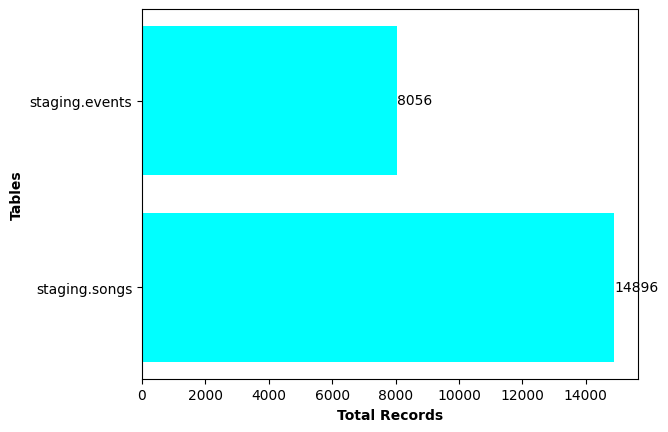

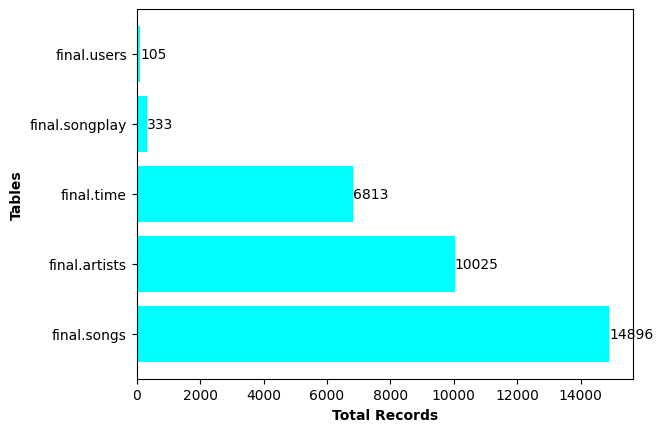

In [94]:
staging_tables = ['staging.events', 'staging.songs']
final_tables = ['final.songplay', 'final.users', 'final.songs', 'final.artists', 'final.time']

showChart(staging_tables, cur)
showChart(final_tables, cur)

Top 10 most active users

In [90]:
query = """
    SELECT fu.user_id, fu.first_name, fu.last_name, COUNT(sp.songplay_id) total_songplay
    FROM final.users fu
    JOIN final.songplay sp ON fu.user_id = sp.user_id
    GROUP BY fu.user_id, fu.first_name, fu.last_name
    ORDER BY total_songplay DESC, user_id
    LIMIT 10
"""
cur.execute(query)
pd.DataFrame(cur.fetchall(), columns=("user_id", "first_name", "last_name", "total_songplay"))

,user_id,first_name,last_name,total_songplay
0,49,Chloe,Cuevas,42
1,97,Kate,Harrell,32
2,80,Tegan,Levine,31
3,44,Aleena,Kirby,21
4,73,Jacob,Klein,18
5,88,Mohammad,Rodriguez,17
6,15,Lily,Koch,15
7,24,Layla,Griffin,13
8,29,Jacqueline,Lynch,13
9,36,Matthew,Jones,13


In [89]:
query = """
    SELECT fa.artist_id, fa.name artist_name, COUNT(fsp.songplay_id) total_songplay
    FROM final.songplay fsp
    JOIN final.artists fa ON fsp.artist_id = fa.artist_id
    GROUP BY fa.artist_id, fa.name
    ORDER BY total_songplay DESC
    LIMIT 10;

"""
cur.execute(query)
pd.DataFrame(cur.fetchall(), columns=("artist_id", "artist_name", "total_songplay"))

,artist_id,artist_name,total_songplay
0,AR5E44Z1187B9A1D74,Dwight Yoakam,37
1,ARD46C811C8A414F3F,Kid Cudi / Kanye West / Common,10
2,ARD46C811C8A414F3F,Kid Cudi,10
3,AR5EYTL1187B98EDA0,Lonnie Gordon,9
4,AR37SX11187FB3E164,Ron Carter,9
5,ARKQQZA12086C116FC,B.o.B,8
6,ARPDVPJ1187B9ADBE9,Usher featuring Jermaine Dupri,6
7,ARR3ONV1187B9A2F59,Muse,6
8,ARPDVPJ1187B9ADBE9,Usher,6
9,ARM0P6Z1187FB4D466,Arctic Monkeys,5


In [88]:
query = """
    SELECT fs.song_id, fs.title, fa.name artist_name, COUNT(fsp.songplay_id) total_songplay
    FROM final.songplay fsp
    JOIN final.songs fs  ON fsp.song_id = fs.song_id
    JOIN final.artists fa ON fsp.artist_id = fa.artist_id
    GROUP BY fs.song_id, fs.title, fa.name
    ORDER BY total_songplay DESC
    LIMIT 10;
"""
cur.execute(query)
pd.DataFrame(cur.fetchall(), columns=("song_id", "title", "artist_name", "total_songplay"))

,song_id,title,artist_name,total_songplay
0,SOBONKR12A58A7A7E0,You're The One,Dwight Yoakam,37
1,SOUNZHU12A8AE47481,I CAN'T GET STARTED,Ron Carter,9
2,SOHTKMO12AB01843B0,Catch You Baby (Steve Pitron & Max Sanna Radio...,Lonnie Gordon,9
3,SOULTKQ12AB018A183,Nothin' On You [feat. Bruno Mars] (Album Version),B.o.B,8
4,SOLZOBD12AB0185720,Hey Daddy (Daddy's Home),Usher featuring Jermaine Dupri,6
5,SOLZOBD12AB0185720,Hey Daddy (Daddy's Home),Usher,6
6,SOARUPP12AB01842E0,Up Up & Away,Kid Cudi,5
7,SOTNHIP12AB0183131,Make Her Say,Kid Cudi,5
8,SOARUPP12AB01842E0,Up Up & Away,Kid Cudi / Kanye West / Common,5
9,SOTNHIP12AB0183131,Make Her Say,Kid Cudi / Kanye West / Common,5


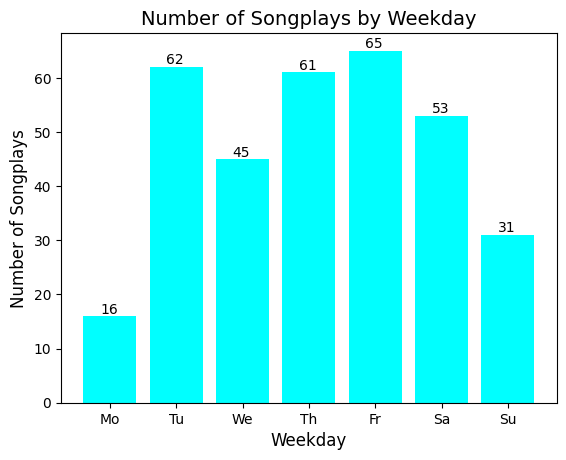

In [91]:
# Replace with your query to get the number of songplays by weekday
query = """
    SELECT weekday, COUNT(songplay_id) AS num_songplays
    FROM final.songplay
    JOIN final.time ON final.songplay.start_time = final.time.start_time
    GROUP BY weekday
    ORDER BY weekday;
"""

cur.execute(query)
results = cur.fetchall()

# Extract the weekday labels and songplay counts from the query results
songplays = np.array([row[1] for row in results])
weekdays = ["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"]

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(weekdays, songplays, color='cyan')

# Add labels and title
ax.set_xlabel('Weekday', fontsize=12)
ax.set_ylabel('Number of Songplays', fontsize=12)
ax.set_title('Number of Songplays by Weekday', fontsize=14)
for i, v in enumerate(songplays):
    ax.text(i - 0.15, v + 0.5, str(v), color='black')

plt.show()

In [98]:
conn.close()

## 6. Delete resources

In [99]:
delete_resources()

Creating clients for IAM, EC2, S3 and Redshift

Delete cluster:

Check cluster:

Cluster is deleting!

Detach iam policy:

Delete iam role:
